In [75]:
import random
import numpy as np
import scanpy as sc
import anndata as an
import scipy.stats as st
from scipy.spatial import KDTree
import math
from numba import njit
from numba import jit
from typing import *


import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams["figure.facecolor"] = "white"

DEBUG = False

In [76]:
def assign_random(adata, K):
    """ Assigns a random factor in range(K) to each
    UMI.

    Parameters:
    ----------
    adata: an.AnnData
        anndata object to study
    K: int
        number of topics
    
    Returns:
    ----------
    A list of lists (one for each spot), containing
    a random factor for each UMI.
    """
    umi_factor_list = []
    all_n_umis = adata.X.sum(axis=1)
    for n_UMIs in all_n_umis:
        factors = np.random.randint(low = 0,
                                    high = K,
                                    size = int(n_UMIs))
        umi_factor_list.append(factors)
    return umi_factor_list

In [112]:
def get_ids_dt_wt(adata: an.AnnData,
                  umi_factors: List[np.ndarray],
                  K: int)->Tuple[np.ndarray,np.ndarray,np.ndarray]:
    """ add short description here
    
    Parameters:
    ----------
    adata : an.AnnData
        anndata object to study
    umi_factors. List[np.ndarray]
        List of arrays. Element j in list i represents
        topic that word j belongs to in spot i
    K: int
        number of topics

    Returns:
    --------
    
    """
    
    n_spots, n_genes = adata.X.shape
    X = adata.X
    ids = []
    dt = np.zeros((n_spots, K)) + 0.1
    wt = np.zeros((K, n_genes)) + 0.1
    
    for spot in range(n_spots):
        ids_spot = []
        spot_list = umi_factors[spot].tolist()
        start = 0
        end = 0
        for gene in range(n_genes):
            n_umis = int(X[spot, gene])
            ids_spot += [gene] * n_umis
            end += n_umis
            for factor in range(K):
                wt[factor, gene] += spot_list[start: end].count(factor)
            start = end
        ids.append(ids_spot)
        for factor in range(K):
            dt[spot, factor] = spot_list.count(factor)
    return ids, dt, wt

In [78]:
def get_theta(dt):
    """ add short description here
    
    Parameters:
    ----------
    """
    theta = dt / dt.sum(axis=1, keepdims=True)
    return theta

In [79]:
def prepare_data(adata : an.AnnData, select_hvg : bool = True)-> an.AnnData:
    adata.var_names_make_unique()
    if select_hvg:
        sc.pp.log1p(adata)
        sc.pp.highly_variable_genes(adata)
        adata = adata[:,adata.var.highly_variable_genes.values]
        adata.X = (np.exp(adata.X) -1).round(0)
    return adata

In [113]:
path = "/Users/juliafoyer/Documents/Skolarbete/Masters_thesis/Scripts/spatial-data-synth/20210402100654897026-synth-data.h5ad"
adata = an.read_h5ad(path)
print(adata)
adata = prepare_data(adata,select_hvg=False)

umi_factors = assign_random(adata, 3)

n_spots,n_genes = adata.shape
ids,dt,wt = get_ids_dt_wt(adata,umi_factors,3)

theta = get_theta(dt)

n_genes = len(adata.var_names)
K = 3
alpha = 5
beta = 1
nz = np.zeros([K]) + n_genes * beta
nz = dt.sum(axis=0)

AnnData object with n_obs × n_vars = 100 × 50
    obs: 'spot'
    var: 'gene'
    uns: 'info'
    obsm: 'spatial', 'theta'
    varm: 'phi'


In [116]:
def gibbsSampling():
    for d, doc in enumerate(ids):
        for index, w in enumerate(doc):
            z = umi_factors[d][index]
            dt[d, z] -= 1
            wt[z, w] -= 1
            nz[z] -= 1
            pz = np.divide(np.multiply(dt[d, :], wt[:, w]), nz)
#            print(pz)
#            print(pz / pz.sum())
#            print(nz)
            z = np.random.multinomial(1, (pz / pz.sum())).argmax()
            umi_factors[d][index] = z 
            dt[d, z] += 1
            wt[z, w] += 1
            nz[z] += 1

In [120]:
for i in range(0, 100):
    gibbsSampling()
#    print(time.strftime('%X'), "Iteration: ", i, " Completed")

In [122]:
def get_theta(dt):
    """ add short description here
    
    Parameters:
    ----------
    """
    theta = dt / dt.sum(axis=1, keepdims=True)
    return theta

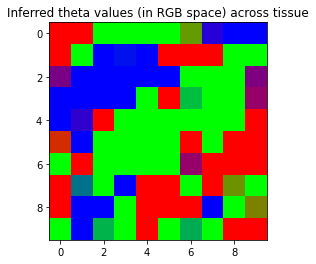

In [124]:
theta_new = get_theta(dt)
side_length = adata.uns["info"]["side_length"]
plt.imshow(theta_new.reshape(side_length,side_length,3))
plt.title("Inferred theta values (in RGB space) across tissue")
plt.show()

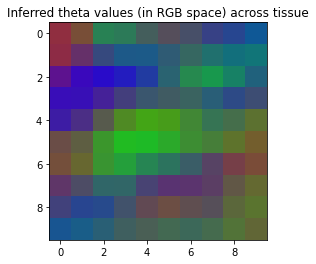

In [84]:
side_length = adata.uns["info"]["side_length"]
plt.imshow(adata.obsm["theta"].reshape(side_length,side_length,3))
plt.title("Inferred theta values (in RGB space) across tissue")
plt.show()